In [1]:
# Imports
import os

# Data science and vis tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Nilearn: Python module for statistical processing of neuroimaging data.
from nilearn import datasets, plotting, image, interfaces

# NiftiMasker is for single regoin of interest
# NiftiMapsMasker is for probablistic atlas
# NiftiLabelsMasker is for discrete atlas
from nilearn.maskers import NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker 

import nibabel as nib # Read and write access to common neuroimaging file formats
import nitime as nit # library for the analysis of time series in the field of neuroimaging. 

C:\Users\dfabe\AppData\Local\Temp\ipykernel_40680\1017377925.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import Atlas

What is melodic FSL?

Melodic is the tool in FSL that we use at both the subject and group level to decompose FMRI data into time-courses and spatial maps using ICA. Dual regression is a tool that we can use as part of a group-level resting state analysis to identify the subject-specific contributions to the group level ICA.

MELODIC (Multivariate Exploratory Linear Optimized Decomposition into Independent Components) analysis. MELODIC is a tool used for independent component analysis (ICA) in functional magnetic resonance imaging (fMRI) data.

In [2]:
melodic_sum_file = os.path.abspath('../../Data/HCP/melodic_IC_sum.nii.gz') # Nifti 4D Data

Plots the different regions in the atlas

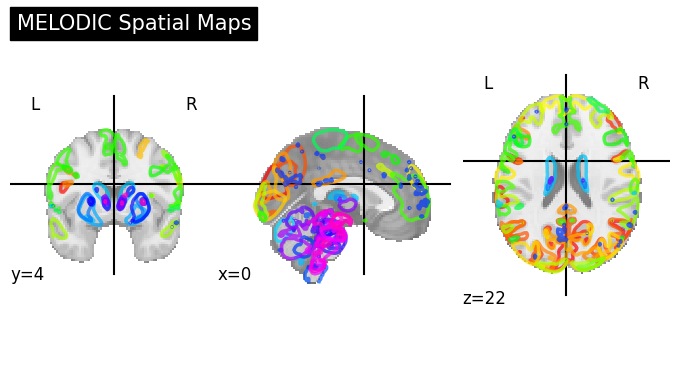

In [3]:
# Load Image
melodic_img = image.load_img(melodic_sum_file)

# Plot melodic spatial maps
plotting.plot_prob_atlas(melodic_img, title='MELODIC Spatial Maps')

### Andrew's Data

Get confounds and compute redisuals

In [4]:
andrew_file = os.path.abspath('../../Data/subject_Andrew/sub-00_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

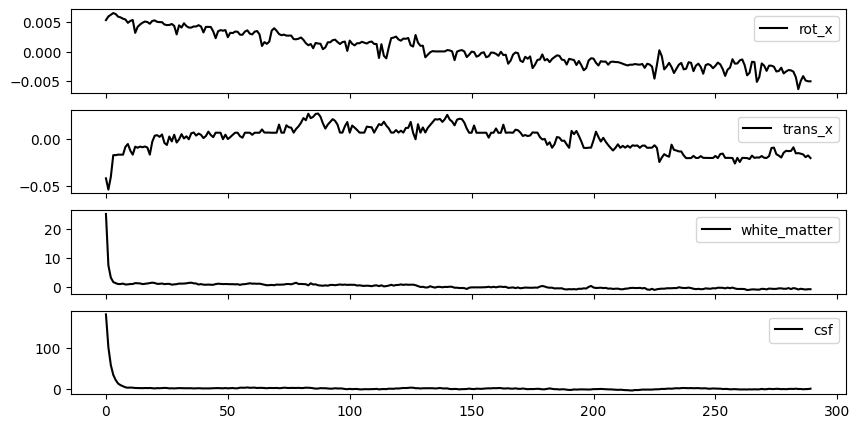

In [5]:
n_drop = 0

img = image.load_img(andrew_file) # Load my file

# get fMRIPrep calculated confounds
confounds = interfaces.fmriprep.load_confounds_strategy(andrew_file, denoise_strategy="simple")[0]

confounds.loc[n_drop:, ["rot_x", "trans_x", "white_matter", "csf"]].plot(
    kind="line", subplots=True, sharex=True, sharey=False, figsize=(10, 5), color="k"
)

In [6]:
masker = NiftiMapsMasker(
    maps_img=melodic_sum_file,
    smoothing_fwhm=6,  # gaussian kernel width (in mm)
    standardize="zscore_sample",  # zero mean, unit variance
    standardize_confounds="zscore_sample",
)

In [7]:
# residuals of OLS, drop first `n_drop` timepoints
time_series = masker.fit_transform(andrew_file, confounds=confounds)[n_drop:, :]
time_series.shape

MemoryError: Unable to allocate 1.95 GiB for an array with shape (902529, 290) and data type float64

In [ ]:
# pairwise correlations
X_corr = time_series.T @ time_series / (time_series.shape[0] - 1)

# partial correlations
# https://en.wikipedia.org/wiki/Partial_correlation#Using_matrix_inversion
X_inv = np.linalg.inv(X_corr)
X_pcorr = -X_inv / np.outer(np.sqrt(np.diag(X_inv)), np.sqrt(np.diag(X_inv)))

# Fill Diagonal to zero
np.fill_diagonal(X_corr, 0)
np.fill_diagonal(X_pcorr, 0)

# plot matrices
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
kwargs = dict(vmin=-0.8, vmax=0.8, colorbar=True)
plotting.plot_matrix(X_corr, axes=axs[0], **kwargs)
plotting.plot_matrix(X_pcorr, axes=axs[1], **kwargs) # Change so more readable

In [ ]:
# Two correlated regions
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].scatter(time_series[:,2], time_series[:,12])

axes[1].plot(time_series[:,2], c = 'steelblue')
axes[1].plot(time_series[:,12], c = 'indianred')
axes[1].set(xlabel ='Time', ylabel = 'Bold Activation', title ='Time Series')

print('Positive Correlation')

**Fisher Transformation**

In [ ]:
# Check if Valid
sum(np.isnan(np.arctanh(X_pcorr).flatten()))

In [ ]:
X_pcorr_trans = np.arctanh(X_pcorr)
X_pcorr_trans[2]

In [ ]:
# Norm of difference
np.linalg.norm(X_pcorr_trans - X_pcorr)

In [ ]:
plotting.plot_matrix(X_pcorr_trans, **kwargs, cmap='hot_black_bone_r')

**Test with Knn Implementation**

In [ ]:
%run KNN.ipynb

Accuracy with k=10 84.86055776892431
Accuracy with k=1 80.87649402390437
Accuracy with k=2 83.26693227091634
Accuracy with k=3 79.6812749003984
Accuracy with k=4 85.65737051792829
Accuracy with k=5 81.27490039840637
Accuracy with k=6 86.85258964143426
Accuracy with k=7 80.0796812749004
Accuracy with k=8 82.07171314741036
Accuracy with k=9 80.47808764940238
Accuracy with k=10 84.86055776892431
Accuracy with k=11 80.47808764940238
Accuracy with k=12 85.65737051792829
Accuracy with k=13 81.27490039840637
Accuracy with k=14 84.06374501992032
Accuracy with k=15 81.67330677290838
Accuracy with k=16 83.26693227091634
Accuracy with k=17 80.0796812749004
Accuracy with k=18 84.06374501992032
Accuracy with k=19 82.47011952191235
Accuracy with k=20 84.86055776892431
Accuracy with k=21 82.07171314741036
Accuracy with k=22 84.4621513944223
Accuracy with k=23 84.06374501992032
Accuracy with k=24 82.86852589641434


In [ ]:
# Verify if my parents lied to me my whole life
knn10.predict([X_pcorr_trans.flatten()])

array(['M'], dtype='<U1')

In [ ]:
distance, index = knn10.kneighbors([X_pcorr_trans.flatten()], 10)

In [ ]:
index

array([[373, 435, 486, 147, 441, 571,  95, 487,  13, 129]])

In [ ]:
data.iloc[index[0]]

,Gender,Age,netmat
subject_id,,,
182739,F,26-30,"[[0.0, -1.0802, 12.834, -12.359, -1.1353, 1.70..."
198855,M,26-30,"[[0.0, 0.90491, 13.742, -6.1279, -0.81053, 3.5..."
210415,F,26-30,"[[0.0, -1.4118, 15.353, -5.7759, 2.0992, 1.383..."
133625,M,26-30,"[[0.0, -0.95397, 17.837, -9.5529, 0.63421, 3.4..."
199958,M,31-35,"[[0.0, 0.22754, 5.3448, -8.1049, 1.4334, 3.609..."
305830,F,22-25,"[[0.0, -2.3737, 12.261, -8.9877, 0.21975, 1.45..."
121618,M,31-35,"[[0.0, -1.313, 14.403, -6.7715, 1.1183, 3.7387..."
210617,F,31-35,"[[0.0, -1.66, 6.0117, -5.1261, 0.74373, 3.8386..."
102715,M,26-30,"[[0.0, -0.87953, 9.0569, -6.9886, 2.7027, 2.17..."


**Plot the brain**

In [ ]:
# Display my big brain (Mean Image)
mean_img = image.mean_img(andrew_file) # The mean of the Time Series Data

In [ ]:
component_img = masker.inverse_transform(np.ones(100))

ValueError: It seems that NiftiMapsMasker has not been fitted. You must call fit() before calling transform().

In [ ]:
plotting.plot_stat_map(component_img, mean_img)

NameError: name 'plotting' is not defined